In [ ]:
import concurrent.futures

from dnachisel.builtin_specifications import EnforceGCContent, EnforceTranslation
from dnachisel.builtin_specifications.codon_optimization import CodonOptimize
from dnachisel.DnaOptimizationProblem import DnaOptimizationProblem, NoSolutionError
import plotnine as p9
import polars as pl

from tools.organism import KAZUSA_HOMO_SAPIENS, load_organism_from_web
from tools.sequence import Sequence
from tools.utils.fasta import parse_fasta_file

In [ ]:
# sequences = list(parse_fasta_file("/home/jon/Downloads/ensembl_ccds_tx_nt_seq_high_gc.fa", "nucleic-acid"))
# sequences += list(parse_fasta_file("/home/jon/Downloads/ensembl_ccds_tx_nt_seq_low_gc.fa", "nucleic-acid"))
sequences = list(parse_fasta_file("/home/jon/Downloads/ensembl_ccds_tx_nt_seq.fa", "nucleic-acid"))
len(sequences)
sequences = [s for s in sequences if len(s[1]) % 3 == 0]
len(sequences)


In [5]:
GC_MIN = 0.0
GC_MAX = 0.65
GC_WINDOW = 50
MIN_CAI = 0.9
ORGANISM = "kazusa-9606"  # human

def _optimize(name: str, input_sequence: Sequence, organism):
    problem = DnaOptimizationProblem(
        sequence=input_sequence.nucleic_acid_sequence,
        constraints=[
            EnforceGCContent(mini=GC_MIN, maxi=GC_MAX, window=GC_WINDOW),
            EnforceTranslation(),
        ],
        objectives=[
            CodonOptimize(
                codon_usage_table=organism.to_dnachisel_dict(),
                method="use_best_codon"
            )
        ],
        logger=None,
    )
    problem.max_random_iters = 20_000

    output_sequence = None
    failed_reason = None
    try:
        problem.resolve_constraints()
        problem.optimize()
        output_sequence = Sequence.from_na(problem.sequence)
        if output_sequence.codon_adaptation_index(organism) < MIN_CAI:
            failed_reason = f"CAI < {MIN_CAI}"
    except NoSolutionError:
        failed_reason = "GC content constraint not resolvable."

    return name, input_sequence, output_sequence, failed_reason

failed: tuple[str, Sequence, Sequence | None, str] = []
organism = load_organism_from_web(ORGANISM)
with concurrent.futures.ProcessPoolExecutor() as executor:
    results = list(
        executor.map(
            _optimize,
            [name for name, sequence in sequences],
            [sequence for name, sequence in sequences],
            [organism for _ in sequences],
        )
    )

In [6]:
failed = [it for it in results if it[3]]
len(failed)

5039

In [7]:
df = pl.DataFrame({
    "name": [it[0] for it in failed],
    "input_sequence": [it[1].nucleic_acid_sequence for it in failed],
    "output_sequence": [it[2].nucleic_acid_sequence if it[2] else None for it in failed],
    "failed_reason": [it[3] for it in failed],
})
df


name,input_sequence,output_sequence,failed_reason
str,str,str,str
"""ENSG00000004776|ENSG0000000477…","""ATGGAGATCCCTGTGCCTGTGCAGCCGTCT…","""ATGGAGATCCCCGTGCCCGTGCAACCTTCT…","""CAI < 0.9"""
"""ENSG00000003249|ENSG0000000324…","""ATGGAGCCCCCGGAGGGCGCCGGCACCGGA…","""ATGGAGCCCCCCGAGGGAGCCGGCACAGGA…","""CAI < 0.9"""
"""ENSG00000173153|ENSG0000017315…","""ATGTCCAGCCAGGTGGTGGGCATTGAGCCT…","""ATGAGCAGCCAGGTGGTGGGCATCGAGCCT…","""CAI < 0.9"""
"""ENSG00000006210|ENSG0000000621…","""ATGGCTCCGATATCTCTGTCGTGGCTGCTC…","""ATGGCCCCCATTTCTCTGAGCTGGCTGCTG…","""CAI < 0.9"""
"""ENSG00000006118|ENSG0000000611…","""ATGTGCGCGCGGATGGCCGGTCGCACAACA…","""ATGTGCGCCAGAATGGCTGGCAGAACCACC…","""CAI < 0.9"""
…,…,…,…
"""ENSG00000101255|ENSG0000010125…","""ATGCGAGCCACCCCTCTGGCTGCTCCTGCG…","""ATGAGAGCCACCCCTCTGGCTGCTCCTGCT…","""CAI < 0.9"""
"""ENSG00000125841|ENSG0000012584…","""ATGATGCCGAGCTGCAATCGTTCCTGCAGC…","""ATGATGCCCAGCTGCAACAGAAGCTGCAGC…","""CAI < 0.9"""
"""ENSG00000284479|ENSG0000028447…","""ATGGCGAGGGCCCCGCAGCCCCGGCGCGGC…","""ATGGCTAGAGCCCCCCAACCTAGAAGAGGA…","""CAI < 0.9"""


In [8]:
df.write_csv("/home/jon/Downloads/ensembl_ccds_tx_nt_seq_failed.fa")

/home/jon/dev/base/mRNArchitect/.venv/lib/python3.13/site-packages/plotnine/geoms/geom_path.py:100: PlotnineWarning: geom_path: Removed 417 rows containing missing values.


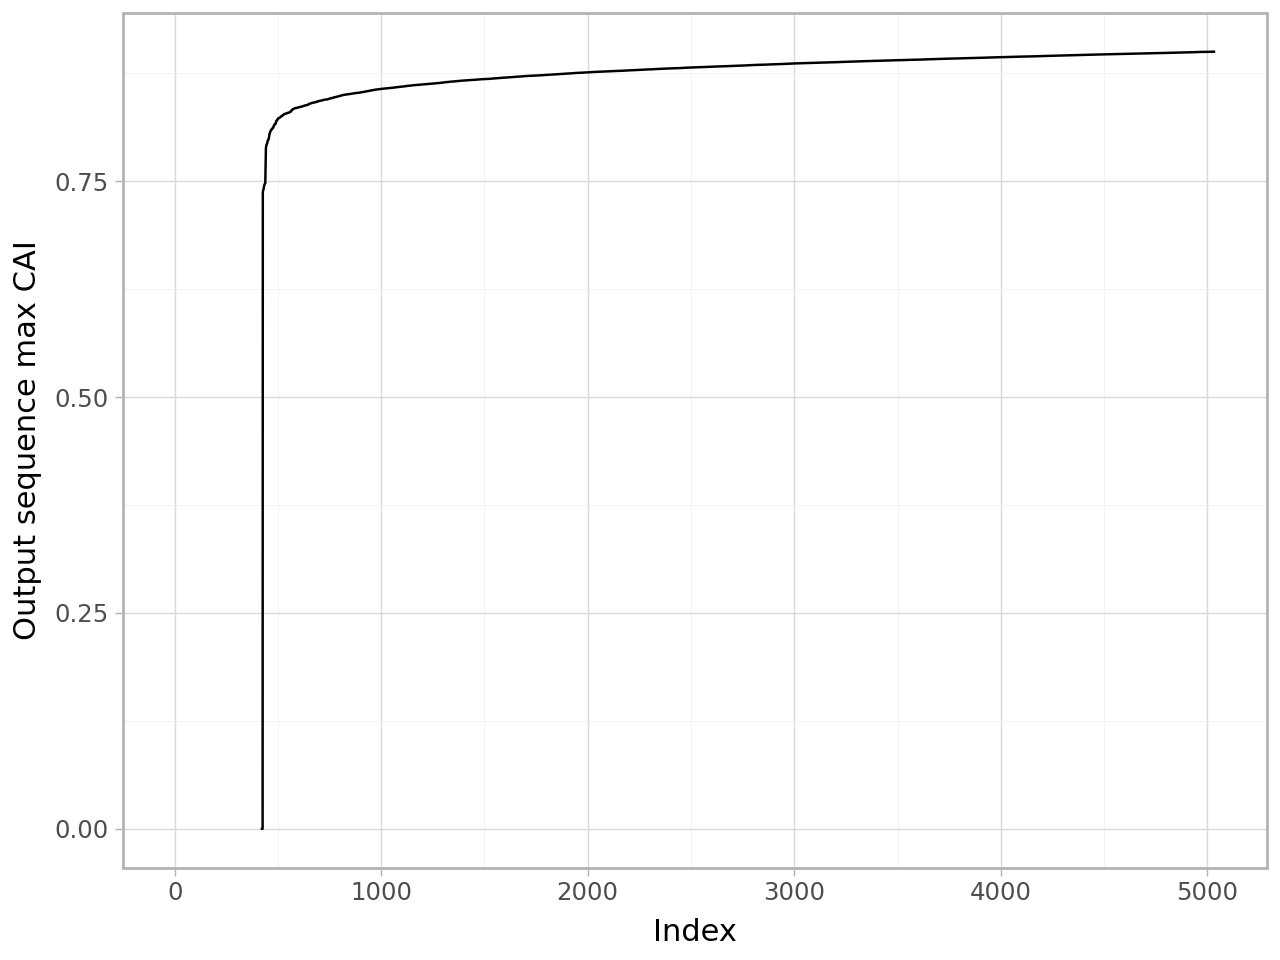

In [23]:
df2 = df.with_columns(
    bp_length=pl.col("input_sequence").map_elements(len, return_dtype=pl.Int64),
    output_cai=pl.col("output_sequence").map_elements(lambda x: Sequence(x).codon_adaptation_index(organism), return_dtype=pl.Float64),
    output_gc_ratio=pl.col("output_sequence").map_elements(lambda x: Sequence(x).gc_ratio, return_dtype=pl.Float64),
)
df2
output_cai_plot = (
    p9.ggplot(df2.sort("output_cai", descending=False).with_row_index(), p9.aes(x="index", y="output_cai"))
    + p9.labs(x="Index", y="Output sequence max CAI")
    + p9.geom_line()
    + p9.theme_light()
)
output_cai_plot

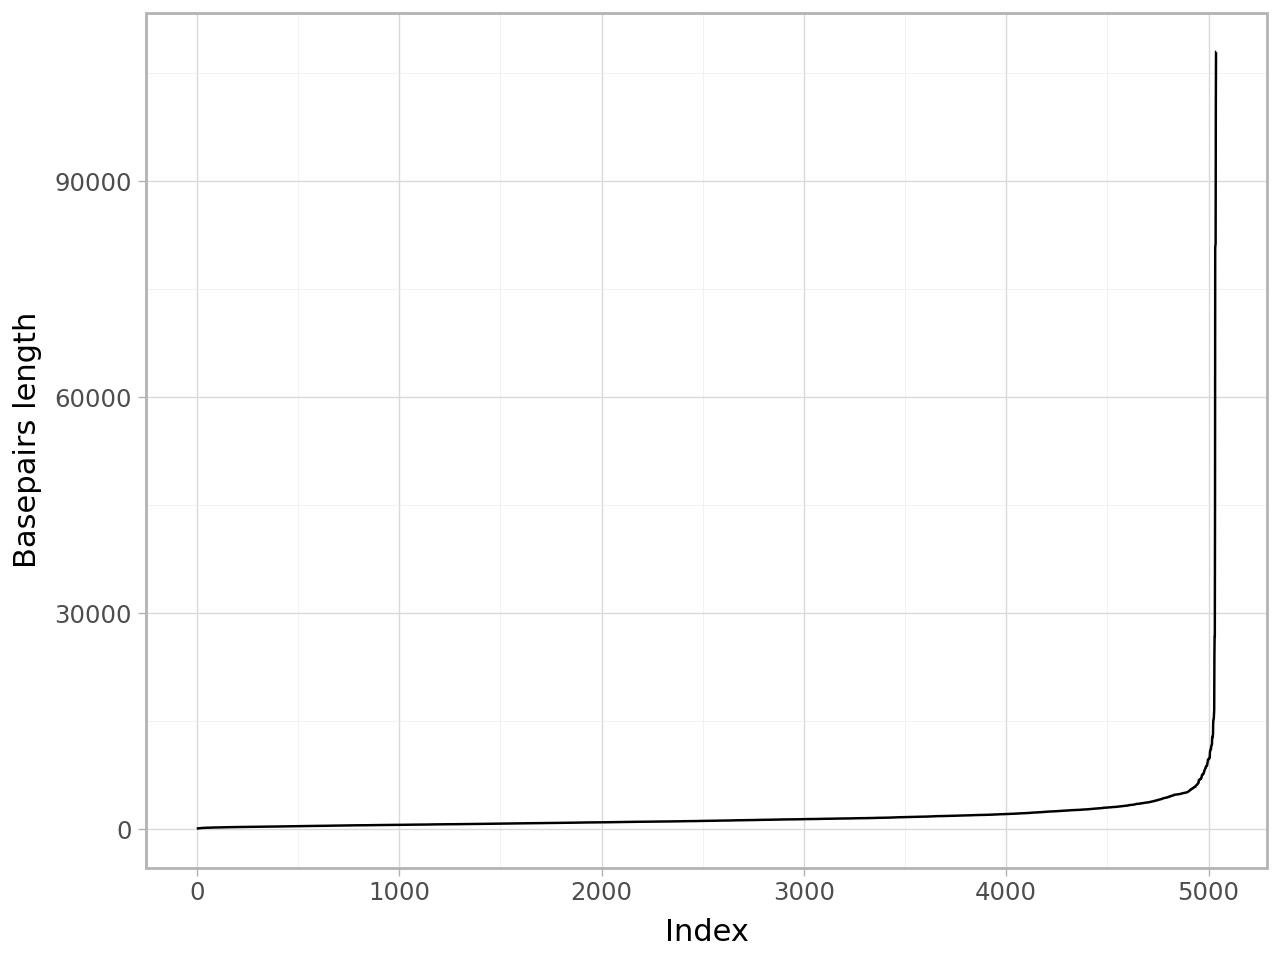

In [11]:
bp_length_plot = (
    p9.ggplot(df2.sort("bp_length", descending=False).with_row_index(), p9.aes(x="index", y="bp_length"))
    + p9.labs(x="Index", y="Basepairs length")
    + p9.geom_line()
    + p9.theme_light()
)
bp_length_plot

/home/jon/dev/base/mRNArchitect/.venv/lib/python3.13/site-packages/plotnine/layer.py:293: PlotnineWarning: stat_pointdensity : Removed 417 rows containing non-finite values.


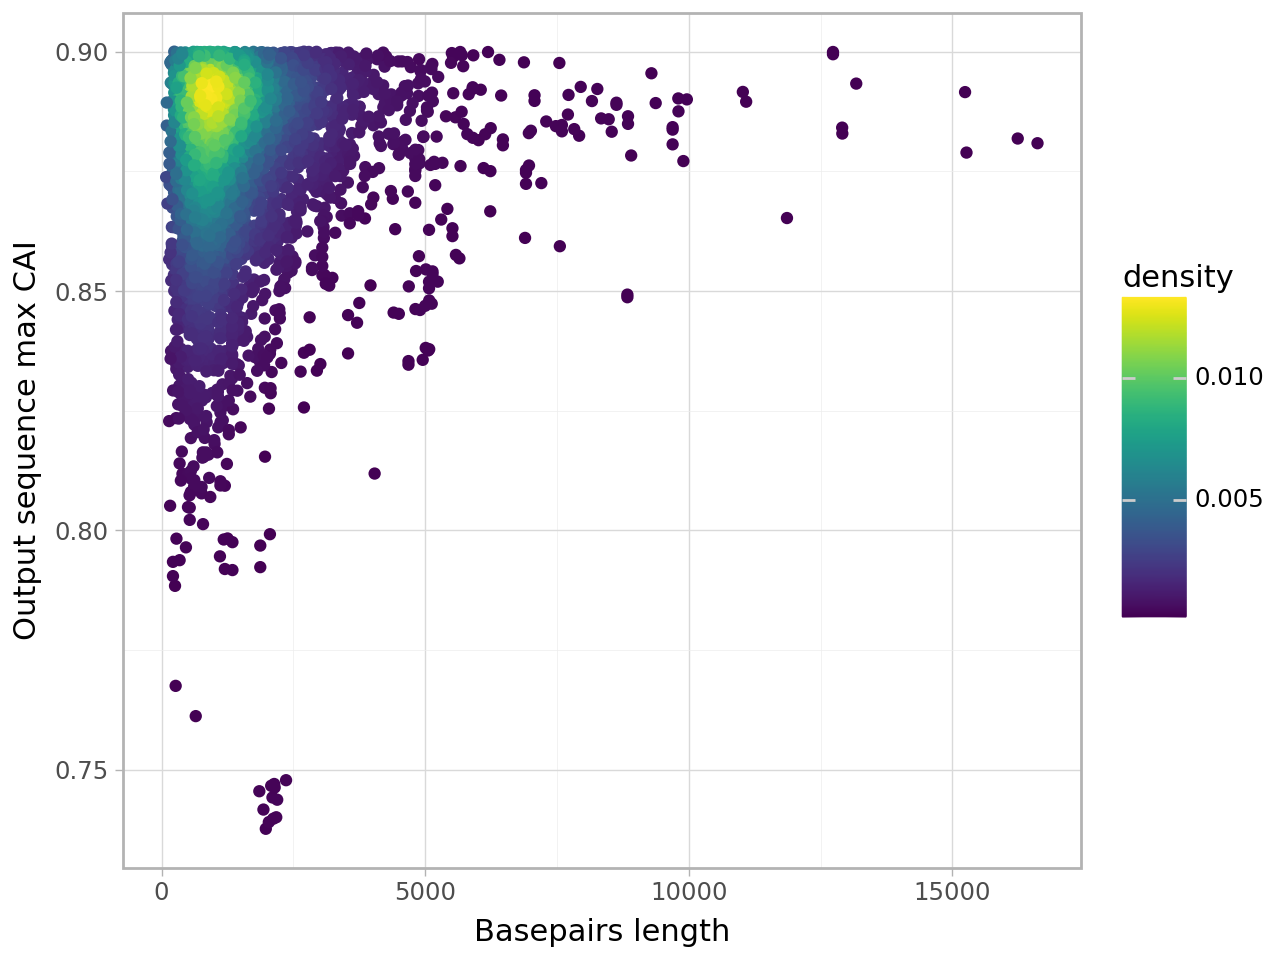

In [25]:
length_vs_cai_plot = (
    p9.ggplot(df2.filter(pl.col("bp_length") < 20000), p9.aes(x="bp_length", y="output_cai"))
    + p9.labs(x="Basepairs length", y="Output sequence max CAI")
    + p9.geom_pointdensity()
    + p9.theme_light()
)
length_vs_cai_plot

In [34]:
df2.filter(pl.col("failed_reason").str.contains("GC"))


name,input_sequence,output_sequence,failed_reason,bp_length,output_cai,output_gc_ratio
str,str,str,str,i64,f64,f64
"""ENSG00000010017|ENSG0000001001…","""ATGTCCGGGCAGCCGCCGCCGCCGCCGCCG…",null,"""GC content constraint not reso…",2190,null,null
"""ENSG00000006047|ENSG0000000604…","""ATGAGCGAGGTGGAGGCGGCAGCGGGGGCT…",null,"""GC content constraint not reso…",1095,null,null
"""ENSG00000038219|ENSG0000003821…","""ATGGCCACCAACCCACAGCCGCAGCCGCCT…",null,"""GC content constraint not reso…",9156,null,null
"""ENSG00000073150|ENSG0000007315…","""ATGCACCACCTCCTGGAGCAGTCGGCGGAC…",null,"""GC content constraint not reso…",1932,null,null
"""ENSG00000053918|ENSG0000005391…","""ATGGCCGCGGCCTCCTCCCCGCCCAGGGCC…",null,"""GC content constraint not reso…",2031,null,null
…,…,…,…,…,…,…
"""ENSG00000048991|ENSG0000004899…","""ATGAGGATGTCTGATACTGTTACTGTAAAA…",null,"""GC content constraint not reso…",3405,null,null
"""ENSG00000015285|ENSG0000001528…","""ATGAGTGGGGGCCCAATGGGAGGAAGGCCC…",null,"""GC content constraint not reso…",1509,null,null
"""ENSG00000203772|ENSG0000020377…","""ATGAACTGGGCACCCGCAACGTGCTGGGCT…",null,"""GC content constraint not reso…",456,null,null


/home/jon/dev/base/mRNArchitect/.venv/lib/python3.13/site-packages/plotnine/layer.py:293: PlotnineWarning: stat_pointdensity : Removed 417 rows containing non-finite values.


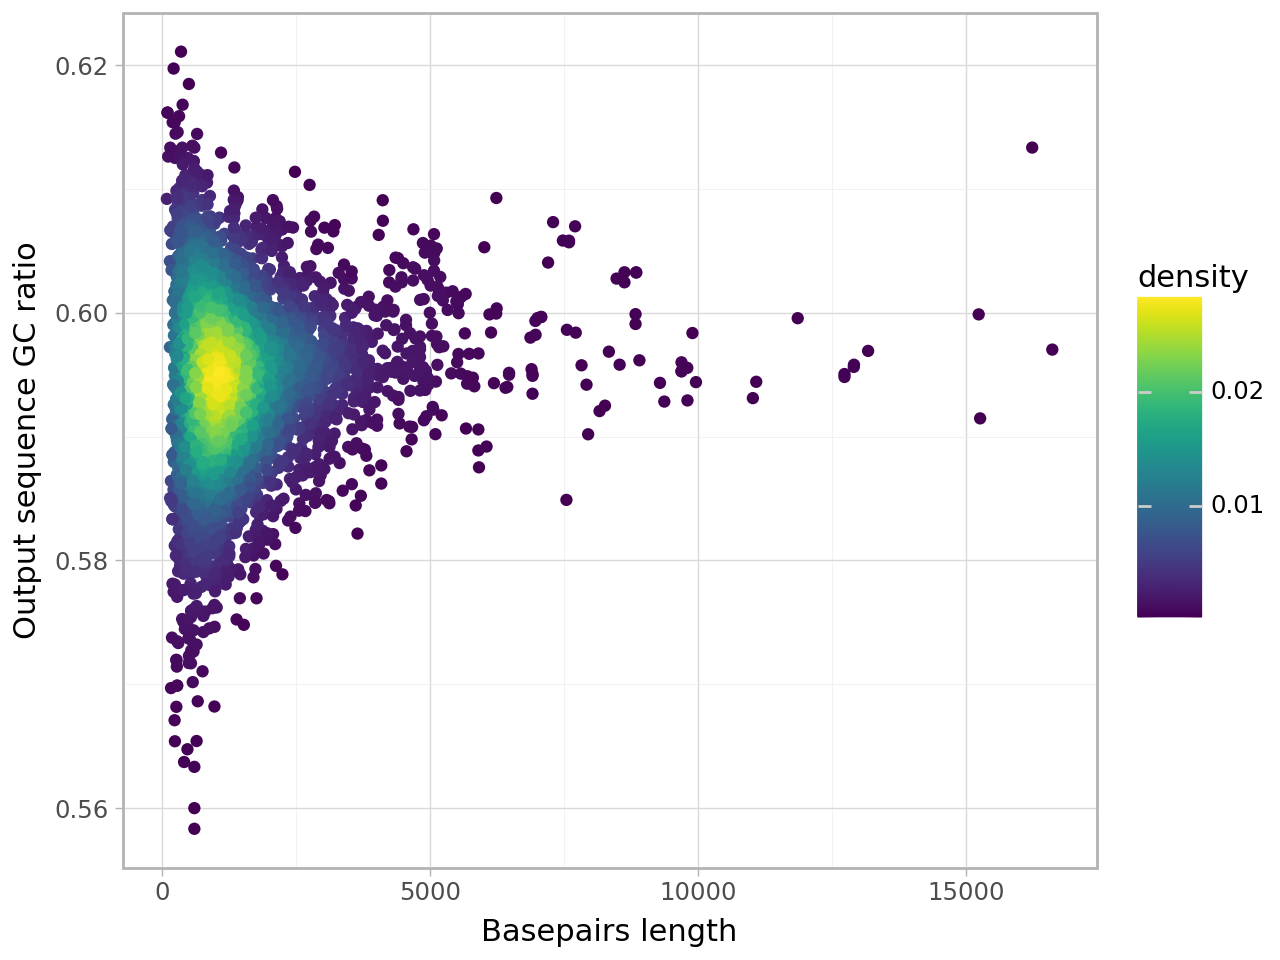

In [35]:
length_vs_gc_content_plot = (
    p9.ggplot(df2.filter(pl.col("bp_length") < 20000), p9.aes(x="bp_length", y="output_gc_ratio"))
    + p9.labs(x="Basepairs length", y="Output sequence GC ratio")
    + p9.geom_pointdensity()
    + p9.theme_light()
)
length_vs_gc_content_plot

In [40]:
df2.filter(pl.col("output_gc_ratio") > 0.5, pl.col("bp_length") > 15000, pl.col("bp_length") < 20000)

name,input_sequence,output_sequence,failed_reason,bp_length,output_cai,output_gc_ratio
str,str,str,str,i64,f64,f64
"""ENSG00000167548|ENSG0000016754…","""ATGGACAGCCAGAAGCTGGCTGGTGAGGAT…","""ATGGACAGCCAGAAGCTGGCCGGCGAGGAC…","""CAI < 0.9""",16614,0.880873,0.597027
"""ENSG00000145113|ENSG0000014511…","""ATGAAGGGGGCACGCTGGAGGAGGGTCCCC…","""ATGAAAGGCGCTAGATGGAGAAGAGTGCCC…","""CAI < 0.9""",16239,0.881854,0.613338
"""ENSG00000261150|ENSG0000026115…","""ATGAGTGGCCACACCTTGCCTCCTCTTCCC…","""ATGTCTGGCCACACCCTTCCTCCTCTTCCC…","""CAI < 0.9""",15267,0.878917,0.591472
"""ENSG00000148357|ENSG0000014835…","""ATGATGCCCGGGGCGCCGCTCCTGCGGCTG…","""ATGATGCCTGGCGCCCCTCTGCTTAGACTG…","""CAI < 0.9""",15240,0.89155,0.599869
